In [51]:
import sys
import os
import re
import time
import datetime
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

sys.path.append('/Users/syz/PycharmProjects/pyUSID/')
#import pyUSID as usid

from numbers import Number
import matplotlib as mpl

def set_tick_font_size(axes, font_size):
    """
    Sets the font size of the ticks in the provided axes
    Parameters
    ----------
    axes : matplotlib.pyplot.axis object or list of axis objects
        axes to set font sizes
    font_size : unigned int
        Font size
    """
    assert isinstance(font_size, Number)
    font_size = max(1, int(font_size))

    def __set_axis_tick(axis):
        """
        Sets the font sizes to the x and y axis in the given axis object
        Parameters
        ----------
        axis : matplotlib.axes.Axes object
            axis to set font sizes
        """
        for tick in axis.xaxis.get_major_ticks():
            tick.label.set_fontsize(font_size)
        for tick in axis.yaxis.get_major_ticks():
            tick.label.set_fontsize(font_size)

    mesg = 'axes must either be a matplotlib.axes.Axes object or an iterable containing such objects'

    if hasattr(axes, '__iter__'):
        for axis in axes:
            assert isinstance(axis, mpl.axes.Axes), mesg
            __set_axis_tick(axis)
    else:
        assert isinstance(axes, mpl.axes.Axes), mesg
        __set_axis_tick(axes)

def parse_compute_line(line):
    # Rank 53 - computed chunk in 2.61 mins or 147.0 msec per pixel. Average: 147.0 msec per pixel.
    matchObj = re.match(r'Rank (.*) - computed chunk in (.*) or (.*) per pixel. Average: (.*) per pixel.', line, re.M|re.I)
    type_list = [int, str, str, str]
    if matchObj:
        raw_vals = [type_caster(matchObj.group(ind)) for ind, type_caster in zip(range(1,1+len(type_list)),type_list)]
        # We are only interested in the third value - time per pixel
        return time_str_to_num(raw_vals[2])
    else:
        return None
    
def parse_write_line(line):
    # Rank 28 - wrote its 1064 pixel chunk in 6.42 sec
    matchObj = re.match(r'Rank (.*) - wrote its (.*) pixel chunk in (.*)', line, re.M|re.I)
    type_list = [int, int, str]
    if matchObj:
        raw_vals = [type_caster(matchObj.group(ind)) for ind, type_caster in zip(range(1,1+len(type_list)),type_list)]
        # We are only interested in the quotient of the third and second values
        return time_str_to_num(raw_vals[2]) / raw_vals[1]
    else:
        return None
    
def parse_execution_time(line):
    # Execution time: 167.08025765419006 sec
    matchObj = re.match(r'\*\*\* (.*) completed in (.*) (.*) \*\*\*', line, re.M|re.I)
    type_list = [str, float ,str]
    if matchObj:
        raw_vals = [type_caster(matchObj.group(ind)) for ind, type_caster in zip(range(1,1+len(type_list)),type_list)]
        # We are only interested in the quotient of the third and second values
        is_guess = True if raw_vals[0] == 'Guess' else False
        if raw_vals[2] == 'sec':
            raw_vals[1] /= 60
        return is_guess, raw_vals[1]
    else:
        return None
    
def parse_log_filename(line):
    # Execution time: 167.08025765419006 sec
    matchObj = re.match(r'BE_SHO_benchmarking_n(.*)_r_(.*)\.(.*)', line, re.M|re.I)
    type_list = [int, int, str]
    if matchObj:
        raw_vals = [type_caster(matchObj.group(ind)) for ind, type_caster in zip(range(1,1+len(type_list)),type_list)]
        # We are only interested in the quotient of the third and second values
        return raw_vals[:2]
    else:
        return None
    
def parse_console_logs(file_path):
    guess_time = None
    fit_time = None
    with open(file_path,mode='r') as file_handle:
        console_output = file_handle.readlines()
        for curr_line in console_output:
            ret_val = parse_execution_time(curr_line)
            if ret_val is not None:
                is_guess, tm = ret_val
                if is_guess:
                    guess_time = tm
                else:
                    fit_time = tm
    return guess_time, fit_time

In [52]:
node_vec = []
ranks_vec = []
guess_times = []
fit_times = []

for file_path in os.listdir():
    if file_path.startswith('BE_SHO_benchmarking'):
        nodes, ranks = parse_log_filename(file_path)
        gs, ft = parse_console_logs(file_path)
        node_vec.append(nodes)
        ranks_vec.append(ranks)
        guess_times.append(gs)
        fit_times.append(ft)

node_vec = np.array(node_vec)
ranks_vec = np.array(ranks_vec)
guess_times = np.array(guess_times)
fit_times = np.array(fit_times)

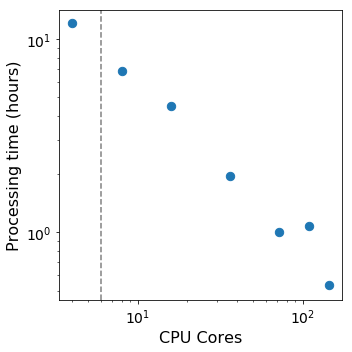

In [77]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.scatter(node_vec * ranks_vec, 10 *(guess_times + fit_times) / 60,
             s=70)
axis.set_xlabel('CPU Cores', fontsize=16)
axis.set_ylabel('Processing time (hours)', fontsize=16)
# axis.set_title('Processing time')
axis.set_xscale('log')
axis.set_yscale('log')
axis.axvline(x=5, linestyle='--', color='gray')
set_tick_font_size(axis, 14)
fig.tight_layout()
fig.savefig('processing_time.png', dpi=300)